In [50]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import eli5
from tqdm import tqdm_notebook

from sklearn.metrics import log_loss, roc_auc_score

In [51]:
SEED = 42

# Load leaks

In [55]:
LEAKS_DIR = './data/'

In [62]:
leaks_train = pd.read_csv(os.path.join(LEAKS_DIR, 'leak_train.csv'), index_col=0).add_prefix('LEAK_')
leaks_test = pd.read_csv(os.path.join(LEAKS_DIR, 'leak_test.csv'), index_col=0).add_prefix('LEAK_')

# Load data

In [68]:
DATA_DIR = './cv/'

In [79]:
splits = []
for fold in ['f1', 'f2', 'f3', 'f4', 'f5']:
    train = pd.read_pickle(os.path.join(DATA_DIR, fold, 'train_features.pkl'))
    test = pd.read_pickle(os.path.join(DATA_DIR, fold, 'test_features.pkl'))
    # Add leaks.
    train = pd.merge(train, leaks_train, how='left', left_index=True, right_index=True)
    test = pd.merge(test, leaks_test, how='left', left_index=True, right_index=True)
    # Fill NaNs.
    train.fillna(-100.0, inplace=True)
    test.fillna(-100.0, inplace=True)
    # Convert to float.
    train = train.astype('float')
    test = test.astype('float')
    splits.append((train, test))

In [80]:
for train, test in splits:
    print(train.shape, test.shape)

(323430, 82) (80858, 82)
(323430, 82) (80858, 82)
(323430, 82) (80858, 82)
(323431, 82) (80857, 82)
(323431, 82) (80857, 82)


In [81]:
FEATURES, TARGET = splits[0][0].columns.difference(['TARGET']), 'TARGET'

# Reweighting

<span style="color:red">**TODO**</span> Choose the best weights

In [83]:
p = 0.3692
q = 0.1746

pos_w = (q/(1-q)) / (p/(1-p))

In [84]:
weights = []
for _, test in splits:
    w = test[TARGET].copy()
    w.loc[test[TARGET] == 0] = 1.0
    w.loc[test[TARGET] == 1] = pos_w
    weights.append(w)

In [85]:
def reweigh(x):
    a = q / p
    b = (1 - q) / (1 - p)
    return a * x / (a * x + b * (1 - x))

def reweigh_alt(x):
#    s = (q/(1-q)) / (p/(1-p))
    s = 0.3627
    return s * x / (s * x + (1 - x))

# Train models

In [86]:
from collections import OrderedDict

In [87]:
metrics = OrderedDict()
metrics_w = OrderedDict()

In [88]:
def quality(metrics):
    folds = ['f1', 'f2', 'f3', 'f4', 'f5']
    df = pd.DataFrame(metrics).T
    df.columns = folds
    df['cv_mean'] = df[folds].mean(axis=1)
    df['cv_std'] = df[folds].std(axis=1)
    return df

## Constant prediction

In [89]:
metrics['const'] = []
metrics_w['const'] = []

for (train, test), w in zip(splits, weights):
    pred = pd.Series(data=train.TARGET.mean(), index=test.index)
    metrics['const'].append(log_loss(test[TARGET], pred))
    metrics_w['const'].append(log_loss(test[TARGET], reweigh(pred), sample_weight=w))

## Logistic regression

In [90]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [91]:
%%time

metrics['lm'] = []
metrics_w['lm'] = []

for (train, test), w in tqdm_notebook(zip(splits, weights)):
    model = LogisticRegression(penalty='l2', C=10.0, n_jobs=10, random_state=SEED)
#    model = SGDClassifier(loss='log', penalty='l2', alpha=0.0001, n_iter=100, n_jobs=16, random_state=SEED)
    model.fit(train[FEATURES], train[TARGET])
    pred = model.predict_proba(test[FEATURES])[:, 1]
    metrics['lm'].append(log_loss(test[TARGET], pred))
    metrics_w['lm'].append(log_loss(test[TARGET], reweigh(pred), sample_weight=w))


CPU times: user 6min 6s, sys: 6.97 s, total: 6min 13s
Wall time: 6min 6s


In [109]:
log_loss(train[TARGET], model.predict_proba(train[FEATURES])[:, 1])

0.069319228580661085

In [92]:
quality(metrics_w)

,f1,f2,f3,f4,f5,cv_mean,cv_std
const,0.463108,0.463108,0.463108,0.463101,0.463101,0.463105,0.000004
lm,0.467163,0.467663,0.464396,0.467197,0.480272,0.469338,0.006247


In [93]:
eli5.show_weights(model, feature_names=FEATURES.tolist())

In [108]:
train.apply(train.TARGET.corr, axis=0, method='spearman')

RAW_agree_qmark            0.012895
RAW_agree_digit            0.113739
RAW_agree_math             0.020205
RAW_contain_math          -0.025441
RAW_agree_how              0.041857
RAW_contain_how           -0.034008
RAW_agree_what             0.044478
RAW_contain_what          -0.038318
RAW_agree_which            0.034177
RAW_contain_which         -0.033127
RAW_agree_who              0.039248
RAW_contain_who           -0.034124
RAW_agree_whom             0.004915
RAW_contain_whom          -0.002278
RAW_agree_where            0.031037
RAW_contain_where         -0.029450
RAW_agree_when             0.057069
RAW_contain_when          -0.056165
RAW_agree_why             -0.006159
RAW_contain_why            0.013333
RAW_diff_len_symb_abs     -0.200114
RAW_diff_len_symb_rel     -0.168502
RAW_diff_len_word_abs     -0.185502
RAW_diff_len_word_rel     -0.157956
RAW_avg_word_min          -0.002327
RAW_avg_word_max          -0.098955
RAW_avg_word_diff         -0.131458
RAW_avg_word_mean         -0

## Random forest

In [94]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [95]:
%%time

metrics['rf'] = []
metrics_w['rf'] = []

for (train, test), w in tqdm_notebook(zip(splits, weights)):
#    model = BaggingClassifier(n_estimators=500, max_samples=0.05, max_features=1.0, n_jobs=16, random_state=SEED)
    model = RandomForestClassifier(n_estimators=500, max_depth=None, min_samples_leaf=1,
                                   max_features='auto', n_jobs=16, random_state=SEED)
    model.fit(train[FEATURES], train[TARGET])
    pred = model.predict_proba(test[FEATURES])[:, 1]
    metrics['rf'].append(log_loss(test[TARGET], pred))
    metrics_w['rf'].append(log_loss(test[TARGET], reweigh(pred), sample_weight=w))


CPU times: user 3h 14min 31s, sys: 28.8 s, total: 3h 15min
Wall time: 13min 22s


In [113]:
quality(metrics_w)

,f1,f2,f3,f4,f5,cv_mean,cv_std
const,0.463108,0.463108,0.463108,0.463101,0.463101,0.463105,0.000004
lm,0.467163,0.467663,0.464396,0.467197,0.480272,0.469338,0.006247
rf,0.300336,0.300350,0.300422,0.301721,0.301755,0.300917,0.000751


In [137]:
eli5.show_weights(model, feature_names=FEATURES.tolist())

Weight,Feature
0.2469,VW_QUAD_BIGRAM_pred
0.1420,LEAK_co_occur_count
0.0720,RAW_tok_set_ratio
0.0601,BOW_TFIDF_sim
0.0573,VW_QUAD_pred
0.0531,JAC_sim
0.0233,RAW_loc_agree
0.0223,LEAK_max_freq
0.0222,RAW_agree_how
0.0151,RAW_tok_sort_ratio


In [141]:
FEATURES_ALL = FEATURES

In [155]:
FEATURES = FEATURES_ALL.difference(['LEAK_co_occur_count', 'LEAK_max_freq', 'LEAK_min_freq'])
#FEATURES = FEATURES_ALL.difference(['VW_LINEAR_pred', 'VW_QUAD_BIGRAM_pred', 'VW_QUAD_pred'])

In [156]:
model = XGBClassifier(max_depth=7, learning_rate=0.5, n_estimators=20, min_child_weight=1, subsample=0.6,
                      base_score=0.2, reg_alpha=0, reg_lambda=0, seed=SEED, missing=-100.0, nthread=15)
model.fit(train[FEATURES], train[TARGET])
pred = model.predict_proba(test[FEATURES])[:, 1]
print(log_loss(test[TARGET], reweigh(pred), sample_weight=w))

0.226409332174


## Gradient boosting

In [46]:
from xgboost import XGBClassifier

In [ ]:
%%time

metrics['xgb'] = []
metrics_w['xgb'] = []
predictions = []

for (train, test), w in tqdm_notebook(zip(splits, weights)):
    model = XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=400, min_child_weight=1,
                          reg_alpha=0, reg_lambda=0, seed=SEED, missing=-1.0)
    model.fit(train[FEATURES], train[TARGET])
    pred = model.predict_proba(test[FEATURES])[:, 1]
    metrics['xgb'].append(log_loss(test[TARGET], pred))
    metrics_w['xgb'].append(log_loss(test[TARGET], reweigh(pred), sample_weight=w))
    predictions.append(pred)


CPU times: user 6h 22min 42s, sys: 28 s, total: 6h 23min 10s
Wall time: 31min 22s


In [48]:
eli5.show_weights(model, feature_names=FEATURES.tolist())

Weight,Feature
0.1763,VW_QUAD_BIGRAM_pred
0.0483,JAC_sim
0.0461,BOW_TFIDF_sim
0.0434,RAW_tok_set_ratio
0.0330,RAW_loc_jaccard
0.0224,RAW_loc_agree
0.0217,RAW_part_tok_set_ratio
0.0209,VW_QUAD_pred
0.0162,RAW_contain_why
0.0158,RAW_agree_digit


In [49]:
quality(metrics_w)

,f1,f2,f3,f4,f5,cv_mean,cv_std
const,0.463108,0.463108,0.463108,0.463101,0.463101,0.463105,0.000004
lm,0.277200,0.257433,0.251052,0.252554,0.281660,0.263980,0.014387
rf,0.222352,0.222238,0.220810,0.220930,0.221955,0.221657,0.000734
xgb,0.221262,0.216252,0.221190,0.218244,0.221256,0.219641,0.002295


## Optimize iterations

In [31]:
import xgboost as xgb

In [36]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.1
params['max_depth'] = 12

d_train = xgb.DMatrix(train[FEATURES], label=train[TARGET], missing=-1.0)
d_test = xgb.DMatrix(test[FEATURES], label=test[TARGET], missing=-1.0)

watchlist = [(d_train, 'train'), (d_test, 'test')]

model = xgb.train(params, d_train, num_boost_round=2000, evals=watchlist,
                  early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.659866	test-logloss:0.661801
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.507294	test-logloss:0.524786
[20]	train-logloss:0.461069	test-logloss:0.489828
[30]	train-logloss:0.440239	test-logloss:0.478208
[40]	train-logloss:0.430818	test-logloss:0.474145
[50]	train-logloss:0.42643	test-logloss:0.472685
[60]	train-logloss:0.423007	test-logloss:0.471891
[70]	train-logloss:0.420204	test-logloss:0.471291
[80]	train-logloss:0.416616	test-logloss:0.470761
[90]	train-logloss:0.413358	test-logloss:0.47052
[100]	train-logloss:0.409876	test-logloss:0.470232
[110]	train-logloss:0.406485	test-logloss:0.469818
[120]	train-logloss:0.403151	test-logloss:0.469656
[130]	train-logloss:0.40106	test-logloss:0.46957
[140]	train-logloss:0.397885	test-logloss:0.469361
[150]	train-logloss:0.396099	test-logloss:0.469305
[160]	train-logloss:0.394087	test-logloss:0.469131

h = 4 [1403]	train-logloss:0.455334	test-logloss:0.47287
h = 7 [647]	train-logloss:0.431506	test-logloss:0.468921
h = 8 [641]	train-logloss:0.417376	test-logloss:0.468568
h = 10 [420]	train-logloss:0.393245	test-logloss:0.468434
h = 12 [259]	train-logloss:0.372919	test-logloss:0.468627

In [38]:
eli5.show_weights(model, feature_names=FEATURES.tolist())

Weight,Feature
0.3677,JAC_sim
0.0614,RAW_contain_math
0.0434,SPACY_jac_sim_PERSON
0.0415,SPACY_jac_sim_OTHER
0.0394,RAW_unicode_jaccard
0.0381,SPACY_jac_sim_LOC
0.0379,SPACY_jac_sim_ORG
0.0360,BOW_TFIDF_sim
0.0323,SPACY_sim
0.0244,SPACY_agree_ORG


In [94]:
quality(metrics_w)

,f1,f2,f3,f4,f5,cv_mean,cv_std
const,0.463108,0.463108,0.463108,0.463101,0.463101,0.463105,0.000004
lm,0.390700,0.390726,0.386173,0.386044,0.397701,0.390269,0.004750
rf,0.321509,0.322129,0.320685,0.321736,0.321758,0.321563,0.000539
xgb,0.311089,0.313258,0.310595,0.311282,0.312639,0.311773,0.001124


In [40]:
quality(metrics_w)

,f1,f2,f3,f4,f5,cv_mean,cv_std
const,0.455039,0.455039,0.455039,0.455031,0.455031,0.455036,0.000004
lm,0.396406,0.397150,0.399276,0.392796,0.395166,0.396159,0.002401
rf,0.349559,0.350514,0.349923,0.348657,0.349792,0.349689,0.000676
xgb,0.340931,0.343111,0.341203,0.340194,0.341874,0.341463,0.001101


# Correlations

In [56]:
df = splits[0][0]

In [62]:
corrs = df.corr(method='spearman')

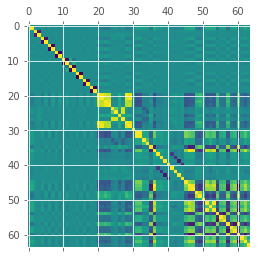

In [63]:
plt.matshow(corrs)

In [64]:
corrs

,RAW_agree_qmark,RAW_agree_digit,RAW_agree_math,RAW_contain_math,RAW_agree_how,RAW_contain_how,RAW_agree_what,RAW_contain_what,RAW_agree_which,RAW_contain_which,...,LDA10_kullback_leibler,LDA10_same_top_topic,LDA10_same_topic_prob,LDA100_kullback_leibler,LDA100_same_top_topic,LDA100_same_topic_prob,LDA500_kullback_leibler,LDA500_same_top_topic,LDA500_same_topic_prob,TARGET
RAW_agree_qmark,1.000000,0.013678,0.000264,-0.012996,0.008494,-0.005759,0.006243,-0.006592,0.005104,-0.005454,...,-0.014732,0.011396,0.015413,-0.018995,0.010814,0.021020,-0.017885,0.011767,0.021319,0.010541
RAW_agree_digit,0.013678,1.000000,0.038078,-0.031906,0.038688,-0.028423,0.037128,-0.031758,0.029740,-0.028811,...,-0.173294,0.117257,0.132880,-0.209152,0.125148,0.176612,-0.225670,0.105041,0.205743,0.114395
RAW_agree_math,0.000264,0.038078,1.000000,-0.792734,0.003276,-0.002685,0.015166,-0.013694,-0.000428,0.000705,...,-0.014341,0.008624,0.005729,-0.021220,0.014732,0.015003,-0.023522,0.016546,0.018426,0.020851
RAW_contain_math,-0.012996,-0.031906,-0.792734,1.000000,-0.002440,0.001965,-0.013408,0.013943,0.001704,-0.002013,...,-0.000842,0.005457,0.015834,0.007486,-0.001339,0.003296,0.007690,-0.002604,0.000306,-0.026455
RAW_agree_how,0.008494,0.038688,0.003276,-0.002440,1.000000,-0.879413,0.027380,-0.025314,0.017732,-0.016327,...,-0.071796,0.043910,0.048650,-0.094177,0.055632,0.077264,-0.109865,0.058215,0.102413,0.040997
RAW_contain_how,-0.005759,-0.028423,-0.002685,0.001965,-0.879413,1.000000,-0.019237,0.017784,-0.013659,0.012171,...,0.043324,-0.018921,-0.011479,0.065162,-0.026733,-0.038069,0.070418,-0.023630,-0.064192,-0.032895
RAW_agree_what,0.006243,0.037128,0.015166,-0.013408,0.027380,-0.019237,1.000000,-0.927705,0.022362,-0.023063,...,-0.071794,0.042500,0.051085,-0.094060,0.055588,0.081180,-0.102649,0.053488,0.098487,0.043115
RAW_contain_what,-0.006592,-0.031758,-0.013694,0.013943,-0.025314,0.017784,-0.927705,1.000000,-0.019852,0.020409,...,0.063823,-0.034184,-0.040143,0.083760,-0.045853,-0.067740,0.087088,-0.042493,-0.084008,-0.036683
RAW_agree_which,0.005104,0.029740,-0.000428,0.001704,0.017732,-0.013659,0.022362,-0.019852,1.000000,-0.965329,...,-0.052135,0.029729,0.030637,-0.069560,0.039952,0.053836,-0.079057,0.035025,0.071649,0.032300
RAW_contain_which,-0.005454,-0.028811,0.000705,-0.002013,-0.016327,0.012171,-0.023063,0.020409,-0.965329,1.000000,...,0.050079,-0.027811,-0.029253,0.067431,-0.038205,-0.053736,0.076149,-0.033244,-0.071789,-0.031462


In [73]:
from itertools import combinations

In [94]:
pair_corrs_list = []
for row, col in combinations(corrs.index, 2):
    cur_corr = corrs.loc[row, col]
    pair_corrs_list.append((row, col, cur_corr))

In [95]:
pair_corrs = pd.DataFrame(pair_corrs_list, columns=['row', 'col', 'corr'])

In [98]:
pair_corrs.loc[pair_corrs.row.str.contains('SPACY') | pair_corrs.col.str.contains('SPACY')].sort_values('corr')

,row,col,corr
1719,SPACY_agree_OTHER,SPACY_jac_sim_OTHER,-0.826004
1694,SPACY_agree_ORG,SPACY_jac_sim_ORG,-0.687010
1743,SPACY_agree_PERSON,SPACY_jac_sim_PERSON,-0.685627
1668,SPACY_agree_LOC,SPACY_jac_sim_LOC,-0.628636
1859,SPACY_sim,LDA500_kullback_leibler,-0.624044
1856,SPACY_sim,LDA100_kullback_leibler,-0.523495
1619,JAC_diff,SPACY_sim,-0.462132
1853,SPACY_sim,LDA10_kullback_leibler,-0.442822
1217,RAW_diff_len_word_rel,SPACY_sim,-0.440140
1136,RAW_diff_len_symb_rel,SPACY_sim,-0.428272
